In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy,error_rate

#### Class for reading the data directly into fast.ai, created by 
https://www.kaggle.com/c/digit-recognizer/discussion/80243#latest-525194

In [2]:
class CustomImageItemList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1) # convert to 3 channels
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        # convert pixels to an ndarray
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        return res

In [3]:
path = '../input'

In [4]:
test = CustomImageItemList.from_csv_custom(path=path, csv_name='test.csv', imgIdx=0)
data = (CustomImageItemList.from_csv_custom(path=path, csv_name='train.csv')
                           .split_by_rand_pct(.2)
                           .label_from_df(cols='label')
                           .add_test(test, label=0)
                           #.transform(tfms)
                           .databunch(bs=64, num_workers=0)
                           .normalize(imagenet_stats))

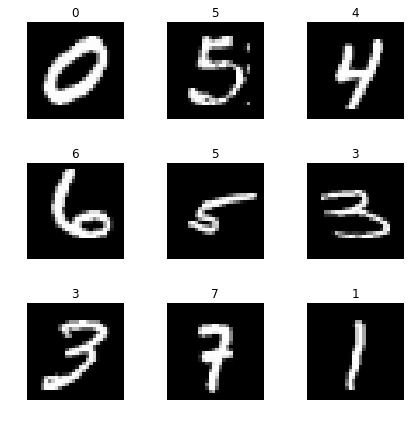

In [5]:
data.show_batch(rows=3, figsize =(6,6))

In [6]:
print(data.classes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate,model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 110173919.30it/s]


In [8]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.696206,0.472997,0.147500,00:25
1,0.326628,0.206083,0.064167,00:23
2,0.220839,0.147106,0.045000,00:24
3,0.178877,0.133898,0.041071,00:23


In [9]:
help(learn.save)

Help on method save in module fastai.basic_train:

save(file:Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO]=None, return_path:bool=False, with_opt:bool=True) method of fastai.basic_train.Learner instance
    Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)



In [10]:
learn.save("model_1", return_path=True)
#doc(learn.save)

PosixPath('/tmp/model/model_1.pth')

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

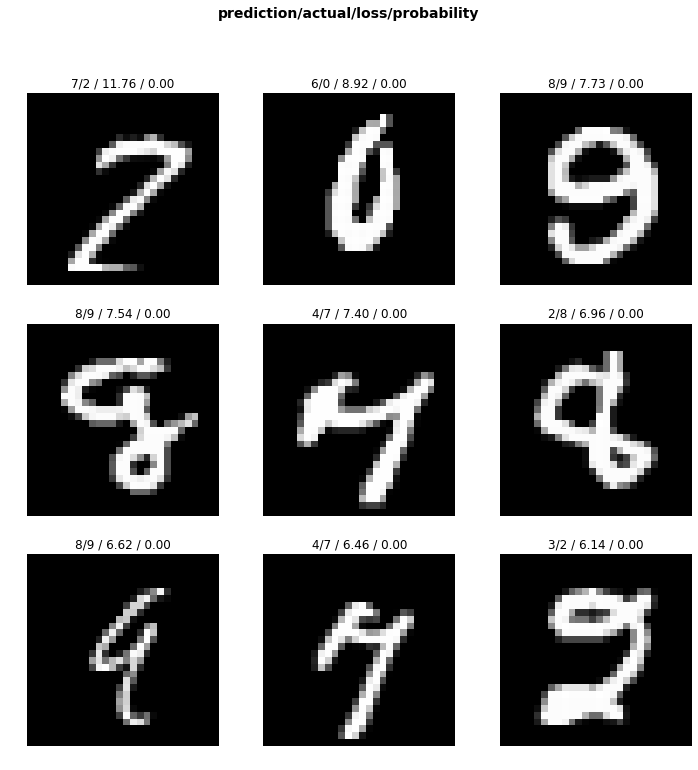

In [12]:
interp.plot_top_losses(9)

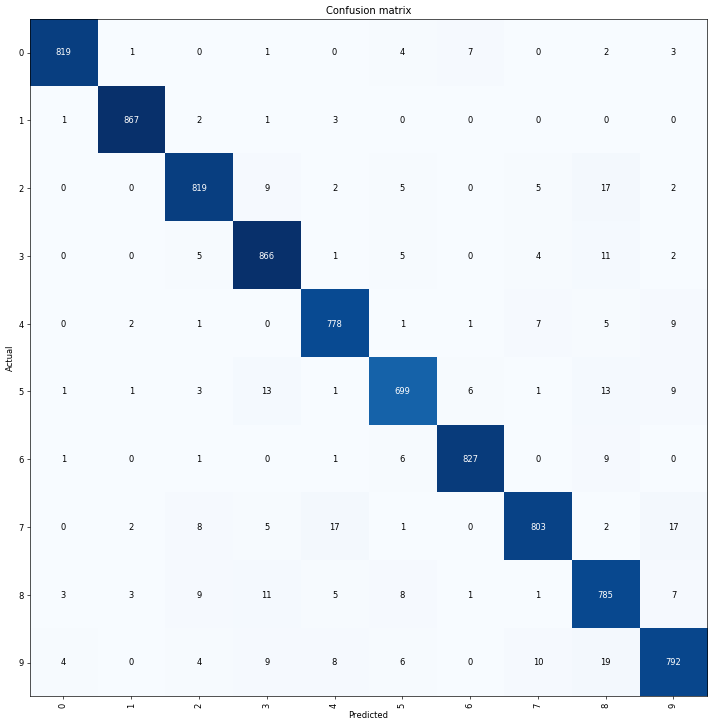

In [13]:
#doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi =60)

In [14]:
interp.most_confused(min_val=3)

[(9, 8, 19),
 (2, 8, 17),
 (7, 4, 17),
 (7, 9, 17),
 (5, 3, 13),
 (5, 8, 13),
 (3, 8, 11),
 (8, 3, 11),
 (9, 7, 10),
 (2, 3, 9),
 (4, 9, 9),
 (5, 9, 9),
 (6, 8, 9),
 (8, 2, 9),
 (9, 3, 9),
 (7, 2, 8),
 (8, 5, 8),
 (9, 4, 8),
 (0, 6, 7),
 (4, 7, 7),
 (8, 9, 7),
 (5, 6, 6),
 (6, 5, 6),
 (9, 5, 6),
 (2, 5, 5),
 (2, 7, 5),
 (3, 2, 5),
 (3, 5, 5),
 (4, 8, 5),
 (7, 3, 5),
 (8, 4, 5),
 (0, 5, 4),
 (3, 7, 4),
 (9, 0, 4),
 (9, 2, 4),
 (0, 9, 3),
 (1, 4, 3),
 (5, 2, 3),
 (8, 0, 3),
 (8, 1, 3)]

In [15]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.061176,0.030987,0.008810,00:28


In [17]:
learn.load('model_1')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: CustomImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
1,0,1,4,0
Path: ../input;

Valid: LabelList (8400 items)
x: CustomImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
9,0,3,2,8
Path: ../input;

Test: LabelList (28000 items)
x: CustomImageItemList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: ../input, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


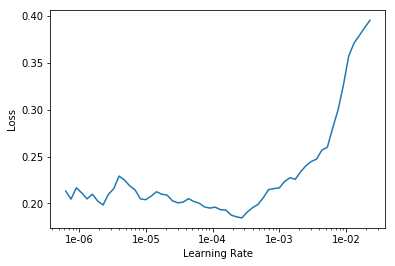

In [19]:
learn.recorder.plot()

In [20]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.141609,0.102061,0.030833,00:28
1,0.117791,0.087858,0.027024,00:28


In [21]:
interp = ClassificationInterpretation.from_learner(learn)

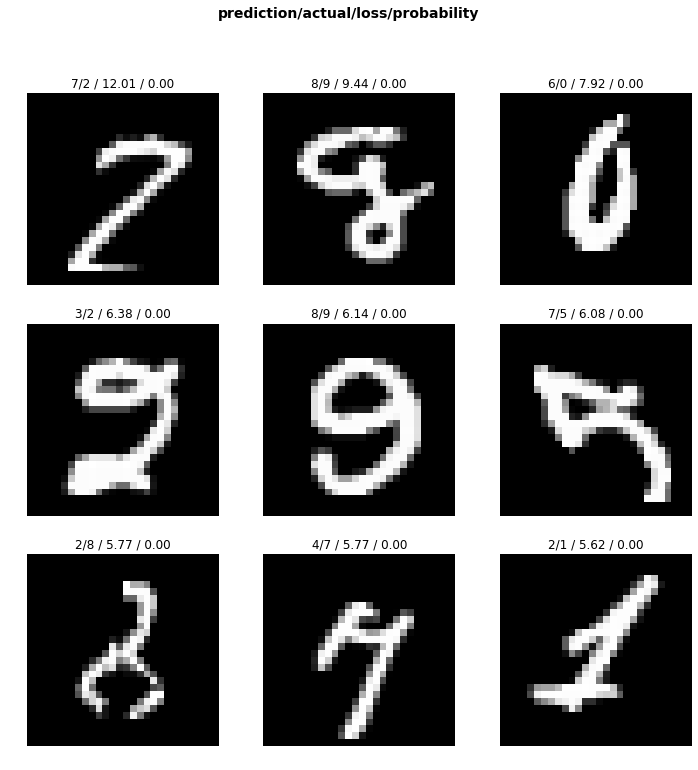

In [22]:
interp.plot_top_losses(9)

#### The code for writing into submission format is taken from:

https://www.kaggle.com/steventesta/digit-recognizer-fast-ai-custom-databunch

In [23]:
# get the predictions
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission.csv', index=False)